# Basic Classifiser for Specific AV

Create a basic classifier for specific vendors, meaning it trains and validates the samples based on a single vendor.

In [1]:
import pandas as pd
import numpy as np
import lib.data_loading as jcfg_data_loading
import lib.helpers as jcfg_helpers
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


test_size = 0.50

# Use the original samples to remove all but the last submission of duplicated samples
samples = pd.read_csv('data/mined_data/pe32_samples.csv')
samples = jcfg_data_loading.set_pd_datetime_index(samples)
samples.drop_duplicates(subset='md5', inplace=True, keep='last')

## Microsoft Classifier

**Ignoring temporal consistency**, train and test a classifier for microsoft only samples

In [2]:
# Load the needed CSVs
static_imports = pd.read_csv('data/mined_data/pe32_static_imports.csv', dtype=str)
static_imports = static_imports.set_index('link')

microsoft_samples = pd.read_csv('data/mined_data/microsoft_classification.csv', dtype=str)
microsoft_samples = microsoft_samples.set_index('link')

# Join the microsoft samples with the imports
dataset = microsoft_samples.join(static_imports).dropna(subset=['imports'])
dataset.drop(['info', 'variant', 'family', 'platform'], axis=1, inplace=True)
# Remove dups
dataset = dataset[dataset.index.isin(samples.link)]

dataset.type.fillna(value=0, inplace=True)

# Filter types of malware
dataset = dataset[(dataset.type == 'backdoor') | (dataset.type == 0)]

dataset.type = dataset.type.replace(to_replace=None, value=1, regex=r'.+').astype(int)
dataset.rename(columns={'type': 'malware'}, inplace=True)

print('Malware in dataset: {}'.format(len(dataset[dataset.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset[dataset.malware == 0])))

Malware in dataset: 13217
Goodware in dataset: 154556


In [3]:
# How imports vary on malware/goodware
microsoft_malware = dataset[dataset.malware == 1]
microsoft_goodware = dataset[dataset.malware == 0]

mcm_count = microsoft_malware.imports.apply(lambda x: len(x.split(';')))
mcg_count = microsoft_goodware.imports.apply(lambda x: len(x.split(';')))

print('Statistics on malware imports:')
display(mcm_count.describe())
print('\nStatistics on goodware imports:')
display(mcg_count.describe())

Statistics on malware imports:


count    13217.000000
mean        82.523114
std        146.634137
min          1.000000
25%          1.000000
50%         15.000000
75%         88.000000
max        880.000000
Name: imports, dtype: float64


Statistics on goodware imports:


count    154556.000000
mean        124.116689
std         176.287262
min           1.000000
25%          19.000000
50%          83.000000
75%         154.000000
max       13325.000000
Name: imports, dtype: float64

CC:	0.9427
DR:	0.3890
FP:	0.2313
FN:	0.0501

Malware stats:


count    6.604000e+03
mean     4.304941e-01
std      3.561690e-01
min      2.117733e-10
25%      1.363583e-01
50%      2.703310e-01
75%      7.932964e-01
max      9.999994e-01
dtype: float64


Goodware stats:


count    77283.000000
mean         0.949944
std          0.098138
min          0.000002
25%          0.929977
50%          0.993952
75%          0.999716
max          1.000000
dtype: float64

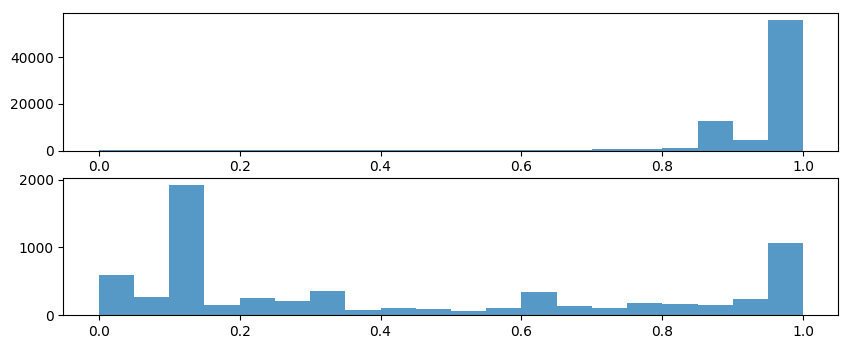

CPU times: user 55 s, sys: 1.06 s, total: 56 s
Wall time: 55.3 s


In [4]:
%%time
# Raw LR, use all imports, dataset balanced as is (more goodware than malware)
# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 13217
Goodware in dataset: 13217
CC:	0.8183
DR:	0.9020
FP:	0.2292
FN:	0.1160

Malware stats:


count    6.558000e+03
mean     7.641505e-01
std      2.333137e-01
min      1.283991e-11
25%      6.515751e-01
50%      7.917073e-01
75%      9.725062e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    6.659000e+03
mean     7.559940e-01
std      2.962718e-01
min      2.207248e-08
25%      4.789039e-01
50%      9.409273e-01
75%      9.964160e-01
max      1.000000e+00
dtype: float64

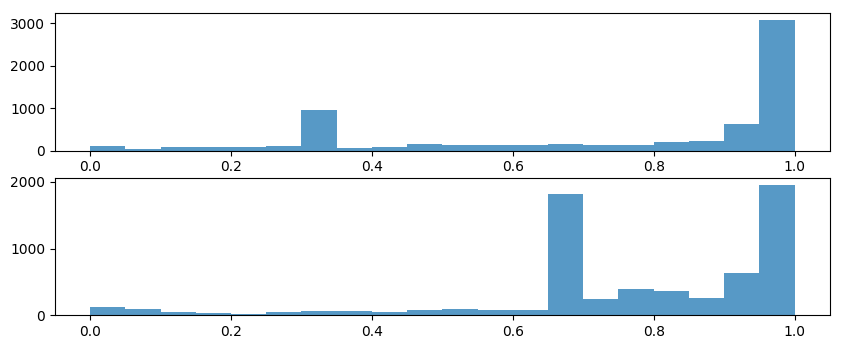

CPU times: user 7.88 s, sys: 447 ms, total: 8.33 s
Wall time: 7.84 s


In [5]:
%%time
# Use all imports, but balance the datasets
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
goodware = dataset[dataset.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset2 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset2[dataset2.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset2[dataset2.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset2, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 13217
Goodware in dataset: 6608
CC:	0.8433
DR:	0.9425
FP:	0.1595
FN:	0.1484

Malware stats:


count    6569.000000
mean        0.845248
std         0.188338
min         0.000003
25%         0.790702
50%         0.894832
75%         0.989099
max         1.000000
dtype: float64


Goodware stats:


count    3.344000e+03
mean     6.639066e-01
std      3.526948e-01
min      8.592617e-08
25%      2.376644e-01
50%      8.275082e-01
75%      9.918658e-01
max      1.000000e+00
dtype: float64

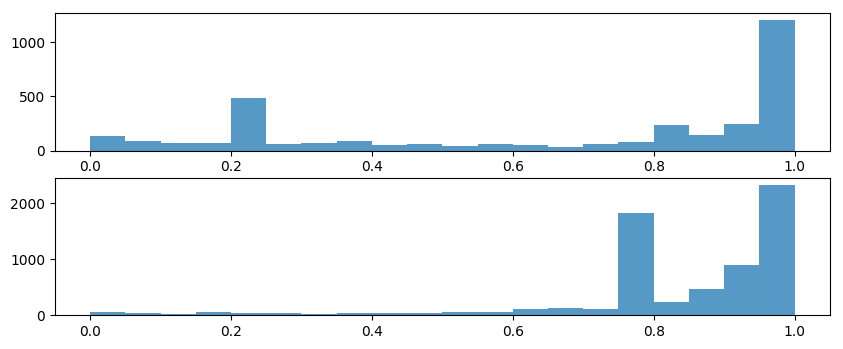

CPU times: user 4.88 s, sys: 397 ms, total: 5.28 s
Wall time: 4.8 s


In [6]:
%%time
# Use all imports, but use more malware for training (more goodware version is default)
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset[dataset.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset3 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset3[dataset3.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset3[dataset3.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset3, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 8394
Goodware in dataset: 116125
CC:	0.9553
DR:	0.4863
FP:	0.2300
FN:	0.0364

Malware stats:


count    4.226000e+03
mean     5.004380e-01
std      3.486956e-01
min      1.276873e-11
25%      1.658055e-01
50%      4.794849e-01
75%      8.281516e-01
max      9.999991e-01
dtype: float64


Goodware stats:


count    58034.000000
mean         0.963545
std          0.097717
min          0.000076
25%          0.978650
50%          0.996525
75%          0.999494
max          1.000000
dtype: float64

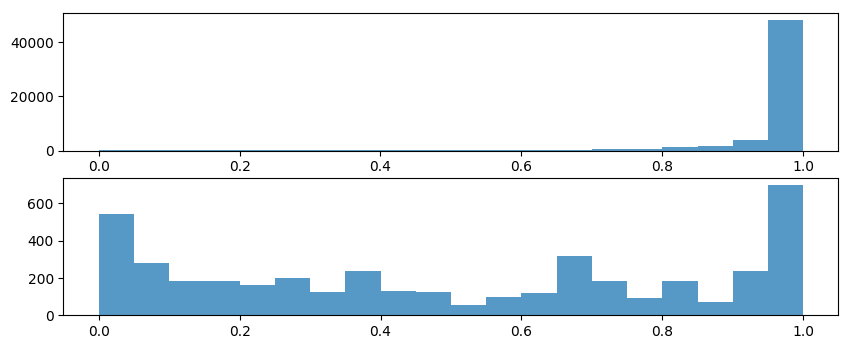

CPU times: user 34.6 s, sys: 503 ms, total: 35.1 s
Wall time: 34.6 s


In [7]:
%%time
# Use between 2 and 300 imports (+/- mean + std for goodware), without balancing
# Filter samples by the number of imports
dataset4 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]

print('Malware in dataset: {}'.format(len(dataset4[dataset4.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset4[dataset4.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset4, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 8394
Goodware in dataset: 8394
CC:	0.8495
DR:	0.8783
FP:	0.1704
FN:	0.1283

Malware stats:


count    4.181000e+03
mean     8.118354e-01
std      2.582682e-01
min      8.605415e-07
25%      7.541624e-01
50%      9.111215e-01
75%      9.858343e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    4213.000000
mean        0.798408
std         0.285218
min         0.000069
25%         0.694467
50%         0.941693
75%         0.992992
max         1.000000
dtype: float64

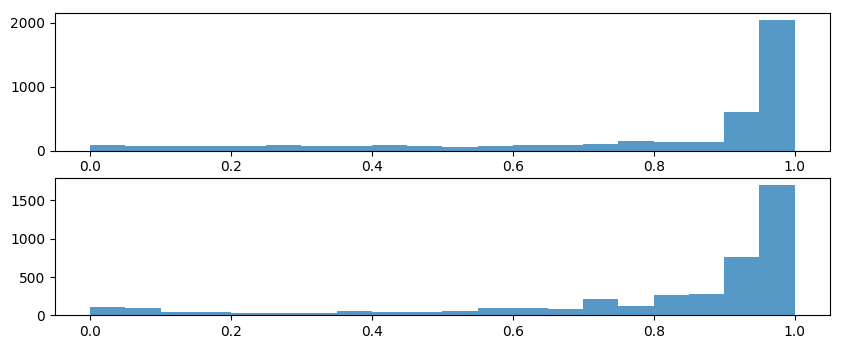

CPU times: user 5.44 s, sys: 367 ms, total: 5.81 s
Wall time: 5.43 s


In [8]:
%%time
# Use between 2 and 300 imports, balanced dataset
dataset5 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset5[dataset5.malware == 1])
goodware_count = len(dataset5[dataset5.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset5[dataset5.malware == 1].sample(n=limiting)
goodware = dataset5[dataset5.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset5 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset5[dataset5.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset5[dataset5.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset5, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 8394
Goodware in dataset: 4197
CC:	0.8693
DR:	0.9271
FP:	0.1156
FN:	0.1670

Malware stats:


count    4.241000e+03
mean     8.706930e-01
std      2.053650e-01
min      8.660268e-10
25%      8.678140e-01
50%      9.425785e-01
75%      9.921650e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    2055.000000
mean        0.729362
std         0.321998
min         0.000010
25%         0.499712
50%         0.866110
75%         0.985377
max         1.000000
dtype: float64

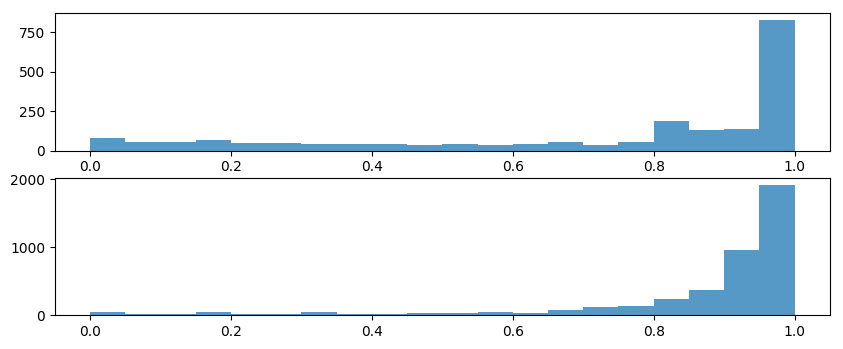

CPU times: user 3.52 s, sys: 467 ms, total: 3.99 s
Wall time: 3.46 s


In [9]:
%%time
# Use up to 300 imports, but with more malware than goodware
dataset6 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset6[dataset6.malware == 1])
goodware_count = len(dataset6[dataset6.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset6[dataset6.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset6[dataset6.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset6 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset6[dataset6.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset6[dataset6.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset6, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()